In [527]:
# CSCI441 Project
# SectionI: Code
# Made by Yousef Kahwaji, Ahmad Akoum, and Mohammad Al Dirani

In [528]:
#recurring imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

In [529]:
#fetching dataset from yfinance
import yfinance as yf
nvda = yf.Ticker("NVDA")
df = nvda.history(period="max")
df.drop(columns=["Dividends",'Stock Splits'], inplace=True) #remove meaningless columns

In [530]:
#engineering meaningful columns. All engineered columns are explained in the report/ppt

from ta.momentum import RSIIndicator
from ta.trend import MACD

#SMA 20,50,100,200. Simple Moving Average.
df['SMA_20'] = df['Close'].rolling(20).mean()
df['SMA_50'] = df['Close'].rolling(50).mean()
df['SMA_100'] = df['Close'].rolling(100).mean()
df['SMA_200'] = df['Close'].rolling(200).mean()

#distance from trend, using sma
df['Close_SMA20_diff']  = df['Close'] / df['SMA_20'] - 1
df['Close_SMA50_diff']  = df['Close'] / df['SMA_50'] - 1
df['Close_SMA100_diff'] = df['Close'] / df['SMA_100'] - 1
df['Close_SMA200_diff'] = df['Close'] / df['SMA_200'] - 1

#RSI 14,30,90. Relative Strength Index. (momentum)
df['RSI14'] = RSIIndicator(close=df['Close'], window=14).rsi()
df['RSI30'] = RSIIndicator(close=df['Close'], window=30).rsi()
df['RSI90'] = RSIIndicator(close=df['Close'], window=90).rsi()

#rate of change. ROC. kinda momentum
df['ROC_5']  = df['Close'].pct_change(5)
df['ROC_10'] = df['Close'].pct_change(10)
df['ROC_20'] = df['Close'].pct_change(20)

#Volatility
df['Vol_5']  = df['Close'].pct_change().rolling(5).std()
df['Vol_10'] = df['Close'].pct_change().rolling(10).std()
df['Vol_20'] = df['Close'].pct_change().rolling(20).std()

#Price Structure (to prevent future leakage)
df['HL_range'] = (df['High'] - df['Low']) / df['Close']
df['OC_range'] = (df['Open'] - df['Close']) / df['Close']

#Trend confirmation
macd = MACD(df['Close'])
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()
df['MACD_diff'] = macd.macd_diff()

#Days and months for pattern recognition
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month

#display all columns
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6777 entries, 1999-01-22 00:00:00-05:00 to 2025-12-30 00:00:00-05:00
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               6777 non-null   float64
 1   High               6777 non-null   float64
 2   Low                6777 non-null   float64
 3   Close              6777 non-null   float64
 4   Volume             6777 non-null   int64  
 5   SMA_20             6758 non-null   float64
 6   SMA_50             6728 non-null   float64
 7   SMA_100            6678 non-null   float64
 8   SMA_200            6578 non-null   float64
 9   Close_SMA20_diff   6758 non-null   float64
 10  Close_SMA50_diff   6728 non-null   float64
 11  Close_SMA100_diff  6678 non-null   float64
 12  Close_SMA200_diff  6578 non-null   float64
 13  RSI14              6764 non-null   float64
 14  RSI30              6748 non-null   float64
 15  RSI90              6688 

In [531]:
#Finalizing the dataset for usage

#Creating Output with threshold to remove noise
df_2 = df.copy()
threshold = 0.005  # 0.5%
df_2['Change'] = np.where((df['Close'].shift(-1) / df['Close'] - 1) > threshold,'UP','DOWN')
df_2 = df_2.iloc[:-1] #removing the last row

#Removing the Close column
df_2.drop(columns=['Close'], inplace=True)

Default (Gini, Untuned)		
TrainTestSplit: 		51.47579693034239
KFold: 					51.1512153174629
Stratified KFold: 		50.87078339809946
Time Series Split: 		50.13286093888398

               precision    recall  f1-score   support

        DOWN       0.58      0.55      0.57       963
          UP       0.44      0.46      0.45       731

    accuracy                           0.51      1694
   macro avg       0.51      0.51      0.51      1694
weighted avg       0.52      0.51      0.52      1694



Entropy Tuned		
TrainTestSplit: 		50.0
KFold: 					48.99622288258281
Stratified KFold: 		50.236173246688224
Time Series Split: 		50.89459698848539

               precision    recall  f1-score   support

        DOWN       0.58      0.43      0.49       963
          UP       0.44      0.60      0.51       731

    accuracy                           0.50      1694
   macro avg       0.51      0.51      0.50      1694
weighted avg       0.52      0.50      0.50      1694



Gini Tuned		
TrainTestS

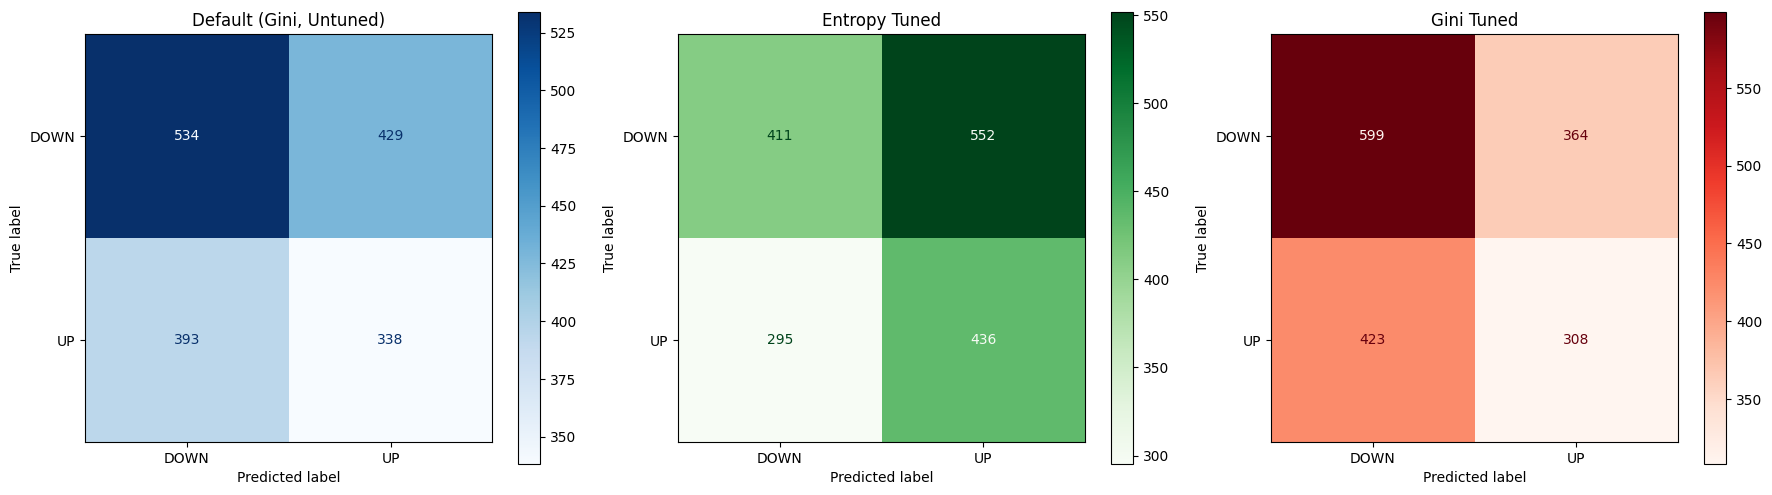

In [532]:
#Model 1: Decision Tree Classifier

#imports
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold, cross_val_score, TimeSeriesSplit
from sklearn.metrics import ConfusionMatrixDisplay

#Preproc
#sklearn DTs do not require removing NaN values, can handle categorical output data, and are not sensitive to the scale of the input variables
#no dropna, no label encoding (the features are all linear in this case), and no standardization / normalization
#DT may require feature selection to avoid overfitting / Dimension reduction

X = df_2.drop(columns=['Change'])
y = df_2['Change']

#Data Splitting
X_train_tts, X_test_tts, y_train_tts, y_test_tts = train_test_split(X, y, test_size=0.25, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tss = TimeSeriesSplit(n_splits=5)

#Training, Testing, Evaluating
dtrees = [DecisionTreeClassifier(random_state=42), DecisionTreeClassifier(random_state=42, criterion='entropy', class_weight='balanced', max_depth=15), DecisionTreeClassifier(random_state=42, criterion='gini', class_weight='balanced', max_depth=17) ]
scores = []
reports = []
splitScores = {
    'KFold': [],
    'StratifiedKFold': [],
    'TimeSeriesSplit': []
}
labels = ['Default (Gini, Untuned)','Entropy Tuned','Gini Tuned']
predicts = []
for model in dtrees:
    model.fit(X_train_tts, y_train_tts)
    y_pred = model.predict(X_test_tts)
    predicts.append(y_pred)
    score = accuracy_score(y_test_tts, y_pred)
    report = classification_report(y_test_tts, y_pred)
    splitScores['KFold'].append(cross_val_score(model, X, y, cv=kf, scoring='accuracy'))
    splitScores['StratifiedKFold'].append(cross_val_score(model, X, y, cv=skf, scoring='accuracy'))
    splitScores['TimeSeriesSplit'].append(cross_val_score(model, X, y, cv=tss, scoring='accuracy'))
    scores.append(score*100)
    reports.append(report)

#Display
for i in range(len(reports)):
    print(labels[i],"\nTrainTestSplit: " ,scores[i],end='\n', sep='\t\t')
    print("KFold: ",np.mean(splitScores['KFold'][i]*100),end='\n', sep='\t\t\t\t\t')
    print("Stratified KFold: ",np.mean(splitScores['StratifiedKFold'][i]*100),end='\n', sep='\t\t')
    print("Time Series Split: ",np.mean(splitScores['TimeSeriesSplit'][i]*100),end='\n', sep='\t\t')
    print("\n",reports[i],end='\n\n\n')

#Plot, Confusion Matrices
fig,axes = plt.subplots(1, 3, figsize=(18, 5))
cmaps = ['Blues', 'Greens', 'Reds']
for i in range(len(dtrees)):
    ConfusionMatrixDisplay.from_estimator(dtrees[i], X_test_tts, y_test_tts, cmap=cmaps[i], ax=axes[i])
    axes[i].set_title(labels[i])
plt.tight_layout()
plt.show()

#Conclusion
#The Decision Tree struggled, between 51% and 54% accuracy. Since 50% is a coin flip, these models aren't finding a strong "edge" in the NVDA data. This
#stayed true even when switching between the splits. The Entropy Tuned Model showed a high f1 balance, but had a 50% accuracy, which is not better than a coin
#flip, it is also highly volatile as shown by the precision and recall values. As for the Default Model, it had a higher accuracy than Entropy; however
#overall, the Gini Tuned Model proved to be the most accurate with a somewhat balanced precision and recall for up and down. Even so, this model still was
#biased towards DOWN and had a relatively low accuracy.
#Therefore, one Decision Tree is NOT suitable for this dataset.